<a href="https://colab.research.google.com/github/custom-hyper/Analytics/blob/main/Screener_%E2%80%93_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Infra

Change Requests:
* Remove zeros of market capitalization
* Combine with other tables that don't often update but are useful for research

In [1]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title pip 
!pip install pytrends --quiet
!pip install pycoingecko --quiet
!pip install pandas --quiet
!pip install requests --quiet
!pip install pipreqs --quiet
!pip install configparser --quiet
!pip install psycopg2-binary==2.8.6 --quiet

!pip install matplotlib --quiet
!pip install mplfinance --quiet

In [3]:
#@title Ta-lib – Extra steps { display-mode: "code" }
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

dpkg-deb: error: 'libta.deb' is not a Debian format archive
dpkg: error processing archive libta.deb (--install):
 dpkg-deb --control subprocess returned error exit status 2
dpkg-deb: error: 'ta.deb' is not a Debian format archive
dpkg: error processing archive ta.deb (--install):
 dpkg-deb --control subprocess returned error exit status 2
Errors were encountered while processing:
 libta.deb
 ta.deb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import mplfinance as fplt
from datetime import datetime as dt
from datetime import timedelta
from datetime import date
import talib as ta
import time
import json
import seaborn as sns
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
#from __future__ import division

## Setup SQLite


In [5]:
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [6]:
#@title   Show Available Tables { display-mode: "code" }
cursor = conn_SQLite.cursor()

%time
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#cursor.execute("DROP TABLE 'proprietary_Twitter_Partnership_ohlc';")
cursor.fetchall()

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.87 µs


[('deFi_lama_total_TVL',),
 ('proprietary_Twitter_Partnership_ohlc',),
 ('proprietary_master_id',),
 ('CoinGecko_ohlc',),
 ('proprietary_tweets_extract',),
 ('proprietary_Twitter_partnerships_announcements',),
 ('proprietary_dashboard',),
 ('watchlist_CoinGecko_ohlc',),
 ('deFi_lama_tvl',),
 ('testing',),
 ('proprietary_airtable_watch_all',),
 ('deFi_lama_general',),
 ('proprietary_Twitter_id',),
 ('CoinGecko_main',),
 ('cal_mvp',),
 ('proprietary_economic_announcement',),
 ('ftx_subaccount_nickname',),
 ('ftx_subaccount_balances',),
 ('ftx_account',),
 ('ftx_positions',),
 ('ftx_wallet_coins',),
 ('ftx_wallet_deposits',),
 ('ftx_wallet_withdrawals',),
 ('ftx_orders_history',),
 ('ftx_fills',),
 ('ftx_funding_payments',),
 ('ftx_balancess',),
 ('ftx_markets',),
 ('ftx_futures',),
 ('CoinGecko_currencies',),
 ('CoinGecko_global',),
 ('CoinGecko_asset_platforms',),
 ('CoinGecko_derivatives',),
 ('CoinGecko_derivatives_exchange_list',),
 ('proprietary_screener_ohlc',),
 ('proprietary_scre

# Extract Data

Data source: [CoinGecko API wrapper](https://github.com/man-c/pycoingecko)

In [7]:
#@title Main – Extract { display-mode: "code" }

frames = []
cg = CoinGeckoAPI()

try:

  start =  1
  ends = 16

  for i in tqdm(range(start,ends)):

    output = cg.get_coins_markets(vs_currency='usd', page = i)
    
    data = pd.json_normalize(output,max_level=4)
    frames.append(data)
    time.sleep(10)

except ConnectionError:
    time.sleep(60)

full_table = pd.concat(frames) #Careful, this line must be outside of the for loop




  0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 99
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1500 non-null   object 
 1   symbol                            1500 non-null   object 
 2   name                              1500 non-null   object 
 3   image                             1500 non-null   object 
 4   current_price                     1500 non-null   float64
 5   market_cap                        1500 non-null   int64  
 6   market_cap_rank                   1500 non-null   int64  
 7   fully_diluted_valuation           939 non-null    float64
 8   total_volume                      1500 non-null   float64
 9   high_24h                          1471 non-null   float64
 10  low_24h                           1471 non-null   float64
 11  price_change_24h                  1471 non-null   float64
 12  price_ch

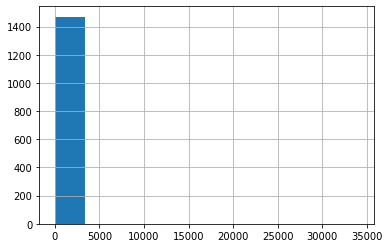

In [9]:
full_table['price_change_percentage_24h'].hist()

In [10]:
#@title Main – Wrangling{ display-mode: "code" }
full_table['price_range_percent_24h'] =  (full_table['high_24h'] - full_table['low_24h'] ) / 0.5*(full_table['high_24h'] + full_table['low_24h'] ) 
full_table['circulating_cap'] = full_table['current_price'] * full_table['circulating_supply']
full_table['total_cap'] = full_table['current_price'] * full_table['total_supply']
full_table['max_cap'] = full_table['current_price'] * full_table['max_supply']
full_table['price_change_percentage_24h'] = full_table['price_change_percentage_24h']/100
full_table['ath_change_percentage'] = full_table['ath_change_percentage']/100
full_table['market_cap_change_percentage_24h'] = full_table['market_cap_change_percentage_24h']/100
full_table['atl_change_percentage'] = full_table['atl_change_percentage']/100
full_table['dilution_change_percentage_24h'] = full_table['market_cap_change_percentage_24h'] - full_table['price_change_percentage_24h']
full_table['prop_timestamp'] = int( time.time_ns() / 1000 )
full_table['prop_timestamp'] = full_table['prop_timestamp'].astype(np.int8)
full_table['CoinGecko_link'] = str('https://www.coingecko.com/en/coins/') + full_table['id']
full_table['symbol'] = full_table['symbol'].str.upper()
#full_table['dilution_ratio'] = full_table['max_supply'] / full_table['circulating_supply']
#full_table['float_rotation_24h'] = full_table['total_volume'] / full_table['market_cap']
full_table['price_change_percentage_24h']  = full_table['price_change_percentage_24h']

#Ranking
full_table['price_range_percent_24h_rank']  =  full_table['price_range_percent_24h'].rank(pct=True)
full_table['total_volume_rank_pct']  =  full_table['total_volume'].rank(pct=True)
full_table['dilution_change_percentage_24h_rank_pct'] = full_table['dilution_change_percentage_24h'].rank(pct=True)
full_table['circulating_cap_rank_pct'] = full_table['circulating_cap'].rank(pct=True)
full_table['total_cap_rank_pct'] = full_table['total_cap'].rank(pct=True)
full_table['max_cap_rank_pct'] = full_table['max_cap'].rank(pct=True)
full_table['price_change_percentage_24h_rank_pct'] = full_table['price_change_percentage_24h'].rank(pct=True)
full_table['market_cap_change_percentage_24h_rank_pct'] = full_table['market_cap_change_percentage_24h'].rank(pct=True)
full_table['market_cap_rank_pct'] = full_table['market_cap'].rank(pct=True)
#full_table['dilution_ratio_rank_pct'] = full_table['dilution_ratio'].rank(pct=True)
#full_table['float_rotation_24h_rank_pct'] = full_table['float_rotation_24h'].rank(pct=True)

#Date
full_table['date'] = date.today()

full_table.replace([np.inf, -np.inf], np.nan, inplace=True)
full_table


,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,price_range_percent_24h_rank,total_volume_rank_pct,dilution_change_percentage_24h_rank_pct,circulating_cap_rank_pct,total_cap_rank_pct,max_cap_rank_pct,price_change_percentage_24h_rank_pct,market_cap_change_percentage_24h_rank_pct,market_cap_rank_pct,date
0,bitcoin,BTC,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,16538.440000,317624500230,1,3.470971e+11,1.877994e+10,16619.140000,...,0.993882,0.999333,0.384615,1.000000,0.999315,1.000000,0.525493,0.512228,1.000000,2022-11-25
1,ethereum,ETH,Ethereum,https://assets.coingecko.com/coins/images/279/...,1198.240000,144352717749,2,1.443527e+11,5.781285e+09,1204.700000,...,0.983685,0.998000,0.413206,0.999333,0.998629,NaN,0.477226,0.466033,0.999333,2022-11-25
2,tether,USDT,Tether,https://assets.coingecko.com/coins/images/325/...,1.000000,65371945090,3,6.537195e+10,2.693606e+10,1.005000,...,0.662814,1.000000,0.599047,0.998667,0.997944,NaN,0.571720,0.578125,0.998667,2022-11-25
3,binancecoin,BNB,BNB,https://assets.coingecko.com/coins/images/825/...,301.690000,49210116412,4,6.027808e+10,9.529253e+08,304.140000,...,0.972128,0.994667,0.460177,0.998000,0.997258,0.998867,0.715160,0.689538,0.998000,2022-11-25
4,usd-coin,USDC,USD Coin,https://assets.coingecko.com/coins/images/6319...,1.001000,44153044510,5,4.425219e+10,2.335570e+09,1.006000,...,0.671652,0.997333,0.831858,0.997333,0.996573,NaN,0.596873,0.655571,0.997333,2022-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,apwine,APW,APWine,https://assets.coingecko.com/coins/images/1559...,0.193504,1866512,1495,9.685575e+06,7.594400e+04,0.196397,...,0.511897,0.355333,0.739959,0.015333,0.253598,0.190260,0.328348,0.350543,0.003333,2022-11-25
96,goztepe-s-k-fan-token,GOZ,Göztepe S.K. Fan Token,https://assets.coingecko.com/coins/images/1512...,0.820629,1848195,1497,NaN,2.029660e+05,0.836641,...,0.757988,0.470667,0.208305,0.014667,0.152844,NaN,0.490823,0.455163,0.002667,2022-11-25
97,primate,PRIMATE,Primate,https://assets.coingecko.com/coins/images/2524...,0.012628,1847429,1500,2.602765e+07,2.501700e+04,0.012976,...,0.242012,0.264000,0.093941,0.014000,0.465387,0.386183,0.282801,0.235734,0.002000,2022-11-25
98,origin-dollar-governance,OGV,Origin Dollar Governance,https://assets.coingecko.com/coins/images/2635...,0.004293,1843813,1498,NaN,1.939390e+05,0.004357,...,0.117607,0.466000,0.665759,0.013333,0.364633,NaN,0.382733,0.396060,0.001333,2022-11-25


In [11]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 99
Data columns (total 46 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         1500 non-null   object 
 1   symbol                                     1500 non-null   object 
 2   name                                       1500 non-null   object 
 3   image                                      1500 non-null   object 
 4   current_price                              1500 non-null   float64
 5   market_cap                                 1500 non-null   int64  
 6   market_cap_rank                            1500 non-null   int64  
 7   fully_diluted_valuation                    939 non-null    float64
 8   total_volume                               1500 non-null   float64
 9   high_24h                                   1471 non-null   float64
 10  low_24h                   

In [12]:

proprietary_screener = "proprietary_screener"

full_table.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

main = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

main.head()


,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,price_range_percent_24h_rank,total_volume_rank_pct,dilution_change_percentage_24h_rank_pct,circulating_cap_rank_pct,total_cap_rank_pct,max_cap_rank_pct,price_change_percentage_24h_rank_pct,market_cap_change_percentage_24h_rank_pct,market_cap_rank_pct,date
0,0chain,ZCN,Züs,https://assets.coingecko.com/coins/images/4934...,0.202758,9813666,843,NaN,7262.19,0.201975,...,0.596193,0.150667,0.315180,0.448667,0.700480,NaN,0.857920,0.845109,0.438667,2022-11-25
1,0x,ZRX,0x,https://assets.coingecko.com/coins/images/863/...,0.195096,164475002,170,194071702.0,9500808.00,0.201498,...,0.582597,0.894667,0.089176,0.888000,0.830706,0.802945,0.215500,0.179348,0.887333,2022-11-25
2,1art,1ART,OneArt,https://assets.coingecko.com/coins/images/1930...,0.015723,2070446,1450,15722934.0,67051.00,0.016469,...,0.253569,0.344000,0.545950,0.046000,0.058259,0.280861,0.083617,0.088315,0.034000,2022-11-25
3,1inch,1INCH,1inch,https://assets.coingecko.com/coins/images/1346...,0.518473,318567521,103,777501598.0,19234952.00,0.528911,...,0.673691,0.932667,0.417971,0.932000,0.939685,0.927520,0.254249,0.254755,0.932000,2022-11-25
4,1world,1WO,1World,https://assets.coingecko.com/coins/images/3443...,0.101399,2548282,1375,NaN,5707.31,0.102190,...,0.405846,0.134000,0.298843,0.094000,0.080192,NaN,0.664854,0.634511,0.083333,2022-11-25


,id,name,market_cap,market_cap_change_24h,content,volume_24h,updated_at
0,fan-token,Fan Token,2.802836e+08,-8.330455,None,6.413314e+07,2022-11-25T19:50:11.048Z
1,sports,Sports,2.395365e+09,-5.672061,These projects have introduced a new way for s...,3.091009e+08,2022-11-25T19:50:29.457Z
2,iotex-ecosystem,IoTeX Ecosystem,2.264968e+08,-4.325842,,1.083315e+07,2022-11-25T19:50:23.448Z
3,terra-ecosystem,Terra Ecosystem,1.194141e+09,-4.290513,None,9.368529e+07,2022-11-25T19:50:11.581Z
4,wrapped-tokens,Wrapped-Tokens,3.767905e+09,-3.912288,Wrapped tokens offer a way to circumvent the l...,1.165310e+09,2022-11-25T19:50:06.708Z
...,...,...,...,...,...,...,...
81,decentralized-options,Options,2.675251e+08,12.483611,None,3.945968e+06,2022-11-25T19:50:18.860Z
82,gaming,Gaming (GameFi),6.817915e+09,14.673311,,5.417874e+08,2022-11-25T19:45:34.834Z
83,prediction-markets,Prediction Markets,3.488386e+08,16.860082,None,2.350205e+07,2022-11-25T19:50:06.331Z
84,metaverse,Metaverse,5.292602e+09,23.151421,Metaverse refers to the part of the Internet w...,3.412593e+08,2022-11-25T19:50:01.681Z


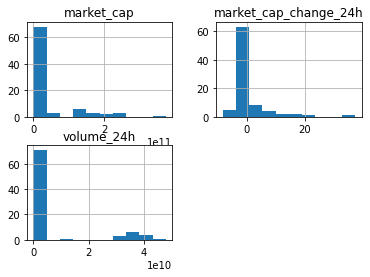

In [13]:
#@title Categories Data { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_coins_categories(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)
del data['top_3_coins']

CoinGecko_derivatives = "CoinGecko_categories"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 
Order by market_cap_change_24h	
""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.hist()
CoinGecko_derivatives




In [14]:
#@title Futures Product { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_derivatives(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output, columns =(
    ['market', 'symbol', 'index_id', 'price', 'price_percentage_change_24h',
       'contract_type', 'index', 'basis', 'spread', 'funding_rate',
       'open_interest', 'volume_24h', 'last_traded_at', 'last_traded_at_f']))

data['last_traded_at_f'] = pd.to_datetime(data['last_traded_at'], unit='s')
CoinGecko_derivatives = "CoinGecko_derivatives"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.head()




,market,symbol,index_id,price,price_percentage_change_24h,contract_type,index,basis,spread,funding_rate,open_interest,volume_24h,last_traded_at,last_traded_at_f
0,Deepcoin (Derivatives),ETHUSDT,ETH,1197.23,-0.370309,perpetual,1198.283300,0.086306,0.02,0.012359,3.354991e+09,4.019328e+08,1669405026,2022-11-25 19:37:06
1,Bitget Futures,BTCUSDT_UMCBL,BTC,16532.27,-0.217286,perpetual,16531.934799,-0.000394,0.01,0.000100,2.271767e+09,2.378615e+09,1669405784,2022-11-25 19:49:44
2,Binance (Futures),BTCUSDT,BTC,16533.72,-0.140758,perpetual,16535.509975,0.033938,0.01,0.005751,2.101862e+09,4.884768e+09,1669405950,2022-11-25 19:52:30
3,Binance (Futures),ETHUSDT,ETH,1198.7,-0.174093,perpetual,1198.713733,0.024510,0.01,0.000738,1.441343e+09,5.052115e+09,1669405950,2022-11-25 19:52:30
4,MEXC Global (Futures),BTC_USDT,BTC,16517.77,-0.332039,perpetual,16518.200000,0.053909,0.01,-0.000200,1.340972e+09,1.307330e+09,1669404565,2022-11-25 19:29:25


In [15]:
output = cg.get_derivatives_exchanges()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

#@title Futures Exchanges { display-mode: "code" }

CoinGecko_derivatives = "CoinGecko_derivatives_exchange_list"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)
CoinGecko_derivatives.head()

,name,id,open_interest_btc,trade_volume_24h_btc,number_of_perpetual_pairs,number_of_futures_pairs,image,year_established,country,description,url
0,Binance (Futures),binance_futures,430274.87,1611432.93,237,42,https://assets.coingecko.com/markets/images/46...,2019.0,None,,https://www.binance.com/
1,BTCEX (Futures),btcex_futures,260153.77,582639.01,84,0,https://assets.coingecko.com/markets/images/75...,NaN,None,,https://www.btcex.com/en-us/
2,BTCC Futures,btcc_futures,236619.07,417424.71,11,63,https://assets.coingecko.com/markets/images/84...,2011.0,None,,https://www.btcc.com/en-US/trade/
3,Bitget Futures,bitget_futures,213045.78,272681.94,108,0,https://assets.coingecko.com/markets/images/59...,NaN,None,,https://www.bitget.com/en/
4,OKX (Futures),okex_swap,206580.29,414581.62,172,603,https://assets.coingecko.com/markets/images/37...,NaN,None,,https://www.okx.com/trade-futures



Reusable scripts

Short
```
WHERE
market_cap > 100000000
AND
dilution_ratio > 6;
```
Long
```
WHERE
price_change_percentage_24h > '2.0e-01'
AND
float_rotation_24h >  0.2
AN
dilution_ratio <  5
```

In [53]:
#@title OHLC { display-mode: "code" }


proprietary_master_id  = "proprietary_screener"

base = pd.read_sql("""

SELECT
id,
market_cap,
price_change_percentage_24h

FROM {}

WHERE
market_cap > 5000000
AND
price_change_percentage_24h > '1.0e-01'
;
""".format(proprietary_master_id), conn_SQLite)

base.info()

,id,market_cap,price_change_percentage_24h
0,dogecoin,12423953612,0.107382
1,huobi-token,890579699,0.209548
2,ecomi,245786080,0.244991
3,mask-network,210202865,0.169765
4,chronobank,137447332,0.410084
5,kaspa,128348653,0.101776
6,ribbon-finance,123087874,0.122362
7,republic-protocol,106334337,0.325464
8,nest,92391189,0.101499
9,beta-finance,63158724,0.201413


In [59]:
from talib.abstract import *

cg = CoinGeckoAPI()
CoinGecko_id = base['id']
frames = []

try:

  start = 0
  ends = len(CoinGecko_id)
  
  for i in tqdm(CoinGecko_id[start:ends]):

    a = cg.get_coin_ohlc_by_id(id=i, vs_currency='usd', days = 'max')

    df = pd.DataFrame(data=a, columns = ['date','open','high', 'low', 'close'])

    df['datetime'] = pd.to_datetime(df['date'], unit='ms')
    df['id'] = str(i)
    df['sma10'] = SMA(df, timeperiod=10,price='close') # calculate on close prices by default
    df['sma20'] = SMA(df, timeperiod=20,price='close') # calculate on close prices by default
    df['sma50'] = SMA(df, timeperiod=50,price='close') # calculate on close prices by default
    df['sma100'] = SMA(df, timeperiod=100,price='close') # calculate on close prices by default
    df['sma200'] = SMA(df, timeperiod=200,price='close') # calculate on close prices by default
    df['atr'] = ATR(df, timeperiod=20) # calculate on close prices by default

    trace1 = {
    'x': df.datetime,
    'open': df.open,
    'close': df.close,
    'high': df.high,
    'low': df.low,
    'type': 'candlestick',
    'name': str(i).upper(),
    'showlegend': True
    }


    trace2 = {
        'x': df.datetime,
        'y': df.sma10,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'yellow'
                },
        'name': 'SMA 10'
    }

    trace3 = {
        'x': df.datetime,
        'y': df.sma20,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'orange'
        },
        'name': 'SMA 20'
    }
    trace4 = {
        'x': df.datetime,
        'y': df.sma50,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'green'
                },
        'name': 'SMA 50'
    }

    trace5 = {
        'x': df.datetime,
        'y': df.sma100,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'blue'
        },
        'name': 'SMA 100'
    }
    trace6 = {
        'x': df.datetime,
        'y': df.sma200,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'purple'
        },
        'name': 'SMA 200'
    }

    data = [trace1, trace2, trace3,trace4,trace5,trace6]

    # Config graph layout
    layout = go.Layout({
        'title': {
            'text': str(i).upper().replace("-"," ") + ' Moving Averages',
            'font': {
                'size': 15
            }
        }
    })

              
      #CHARTING
    fig = go.Figure(data=data, layout=layout)
    fig.show()


    CoinGeckoAPI
    #time.sleep(60/50)
    frames.append(df)
    

except ConnectionError:
  time.sleep(60)

single = pd.concat(frames) #Careful, this line must be outside of the for loop
single['prop_timestamp'] = int( time.time_ns() / 1000 )

single['query_date'] = date.today()
fig.write_html("Moving Averages.html")

  0%|          | 0/33 [00:00<?, ?it/s]

In [62]:
single.tail()


,date,open,high,low,close,datetime,id,sma10,sma20,sma50,sma100,sma200,atr,prop_timestamp,query_date
96,1668124800000,0.000619,0.000619,0.000434,0.000434,2022-11-11,omax-token,0.000778,0.001121,0.001268,NaN,NaN,0.000209,1669407466317175,2022-11-25
97,1668470400000,0.000435,0.000460,0.000435,0.000435,2022-11-15,omax-token,0.000703,0.001065,0.001247,NaN,NaN,0.000200,1669407466317175,2022-11-25
98,1668816000000,0.000439,0.000544,0.000361,0.000544,2022-11-19,omax-token,0.000646,0.001018,0.001232,NaN,NaN,0.000199,1669407466317175,2022-11-25
99,1669161600000,0.000533,0.000533,0.000474,0.000474,2022-11-23,omax-token,0.000588,0.000961,0.001217,0.002146,NaN,0.000193,1669407466317175,2022-11-25
100,1669507200000,0.000574,0.000574,0.000553,0.000553,2022-11-27,omax-token,0.000548,0.000906,0.001205,0.002116,NaN,0.000188,1669407466317175,2022-11-25


In [63]:
proprietary_screener = "proprietary_screener_ohlc"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

ohlc = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

ohlc

,date,open,high,low,close,datetime,id,sma10,sma20,sma50,sma100,sma200,atr,prop_timestamp,query_date
0,1669507200000,0.078422,0.078422,0.073819,0.073819,2022-11-27 00:00:00,asd,0.086115,0.096567,0.097403,0.186508,0.328928,0.009136,1669407466317175,2022-11-25
1,1669507200000,0.521319,0.659794,0.521319,0.659794,2022-11-27 00:00:00,battle-world,0.425918,0.402758,NaN,NaN,NaN,0.066549,1669407466317175,2022-11-25
2,1669507200000,0.080956,0.082849,0.080956,0.082849,2022-11-27 00:00:00,beta-finance,0.078245,0.089423,0.105272,0.339946,NaN,0.017547,1669407466317175,2022-11-25
3,1669507200000,0.064206,0.144386,0.064206,0.144386,2022-11-27 00:00:00,blank,0.067904,0.058480,0.059766,0.276041,NaN,0.019994,1669407466317175,2022-11-25
4,1669507200000,0.005081,0.005081,0.004908,0.004908,2022-11-27 00:00:00,cere-network,0.005299,0.005758,0.006562,0.031240,NaN,0.000761,1669407466317175,2022-11-25
5,1669507200000,143.580000,152.150000,143.580000,152.150000,2022-11-27 00:00:00,chronobank,70.211000,65.437000,56.657600,92.124600,53.864800,11.741529,1669407466317175,2022-11-25
6,1669507200000,0.011440,0.011953,0.011440,0.011953,2022-11-27 00:00:00,crown,0.038933,0.025891,0.021133,0.029172,0.060905,0.047976,1669407466317175,2022-11-25
7,1669507200000,0.082338,0.082338,0.081835,0.081835,2022-11-27 00:00:00,dogecoin,0.091566,0.075858,0.072040,0.113416,0.139701,0.009739,1669407466317175,2022-11-25
8,1669507200000,0.000732,0.000872,0.000732,0.000872,2022-11-27 00:00:00,ecomi,0.001152,0.001215,0.001387,0.003112,0.003206,0.000152,1669407466317175,2022-11-25
9,1669507200000,0.429910,0.437154,0.429910,0.437154,2022-11-27 00:00:00,epic-cash,0.457695,0.472780,0.671981,1.524612,1.014961,0.082908,1669407466317175,2022-11-25


In [67]:
#@title Other Historical { display-mode: "code" }
from talib.abstract import *
import pandas as pd
import numpy as np

cg = CoinGeckoAPI()
CoinGecko_id = base['id']
frames = []


try:
  start = 0
  ends = len(CoinGecko_id)
  for i in tqdm(CoinGecko_id[start:ends]):

    a = cg.get_coin_market_chart_by_id(id=i, vs_currency='usd', days = 'max')

    b = a['prices']
    df1 = pd.DataFrame(b, columns = ['date','price'])
    df1['datetime'] = pd.to_datetime(df1['date'], unit='ms')
    df1.set_index("date", inplace = True)

    c = a['market_caps']
    df2 = pd.DataFrame(c, columns = ['date','market_cap'])
    df2.set_index("date", inplace = True)

    d = a['total_volumes']
    df3 = pd.DataFrame(d, columns = ['date','volume'])   
    df3.set_index("date", inplace = True)

    result = pd.concat([df1, df2,df3], ignore_index=False,axis=1)

    result['id'] = i
    result['stdev_30d'] = result['price'].rolling(30).std()
    result['volume_30d'] = result['volume'].rolling(30).mean()
    result['rel_volume'] = result['volume'] / result['volume_30d'] 
    result['float_rotation'] = result['volume'] / result['market_cap'] 
    

    frames.append(result)
    time.sleep(60/50)
except ConnectionError:
    time.sleep(60)
single = pd.concat(frames) #Careful, this line must be outside of the for loop



single.tail()

  0%|          | 0/33 [00:00<?, ?it/s]

,price,datetime,market_cap,volume,id,stdev_30d,volume_30d,rel_volume,float_rotation
date,,,,,,,,,
1669075200000,0.000497,2022-11-22 00:00:00,4.772214e+06,3956.037803,omax-token,0.000077,788521.526523,0.005017,0.000829
1669161600000,0.000474,2022-11-23 00:00:00,4.558375e+06,231.791981,omax-token,0.000077,691185.153639,0.000335,0.000051
1669248000000,0.000574,2022-11-24 00:00:00,5.498256e+06,1898.073775,omax-token,0.000077,595776.659554,0.003186,0.000345
1669334400000,0.000553,2022-11-25 00:00:00,5.301912e+06,581.909764,omax-token,0.000076,568597.056381,0.001023,0.000110
1669401585000,0.000576,2022-11-25 18:39:45,5.529264e+06,1934.667204,omax-token,0.000076,540579.681731,0.003579,0.000350


In [68]:
from numpy.lib.twodim_base import histogram2d

proprietary_screener = "proprietary_screener_hist"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=True) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost. WHERE datetime CONTAINS '2021'

hist = pd.read_sql("""
select 
*
from {}  

Group by id


""".format(proprietary_screener), conn_SQLite)

hist

,date,price,datetime,market_cap,volume,id,stdev_30d,volume_30d,rel_volume,float_rotation
0,1669370721000,0.074402,2022-11-25 10:05:21,5.526140e+07,1.841348e+06,asd,0.020492,1.994196e+06,0.923353,3.332069e-02
1,1669396102000,0.896144,2022-11-25 17:08:22,5.244183e+07,1.918242e+06,battle-world,0.123072,1.123055e+06,1.708057,3.657846e-02
2,1669378506000,0.092897,2022-11-25 12:15:06,5.783997e+07,3.415479e+07,beta-finance,0.011404,7.601766e+06,4.493008,5.905050e-01
3,1669401109000,0.140827,2022-11-25 18:31:49,5.784690e+06,1.665445e+06,blank,0.025846,3.066930e+05,5.430332,2.879056e-01
4,1669396367000,0.005637,2022-11-25 17:12:47,2.519316e+07,7.664531e+05,cere-network,0.000524,7.679053e+05,0.998109,3.042307e-02
5,1669371217000,162.349128,2022-11-25 10:13:37,1.155740e+08,5.845153e+06,chronobank,32.638102,1.486149e+06,3.933087,5.057500e-02
6,1669404655000,0.195771,2022-11-25 19:30:55,6.065970e+06,4.632548e-03,crown,0.080440,1.927210e+02,0.000024,7.636946e-10
7,1669366109000,0.082197,2022-11-25 08:48:29,1.128053e+10,4.592589e+08,dogecoin,0.020056,2.911843e+09,0.157721,4.071252e-02
8,1669378253000,0.000884,2022-11-25 12:10:53,2.388120e+08,2.983835e+06,ecomi,0.000330,1.627381e+06,1.833519,1.249449e-02
9,1669397813000,0.493513,2022-11-25 17:36:53,7.576526e+06,1.175913e+04,epic-cash,0.043996,7.686898e+03,1.529763,1.552048e-03


In [96]:
df =  base.join(ohlc)

df1 = df.merge(hist, on='id', how='left')
df1

,market_cap_x,price_change_percentage_24h,date_x,open,high,low,close,datetime_x,sma10,sma20,...,query_date,date_y,price,datetime_y,market_cap_y,volume,stdev_30d,volume_30d,rel_volume,float_rotation
id,,,,,,,,,,,,,,,,,,,,,
dogecoin,12423953612,0.107382,1669507200000,0.082338,0.082338,0.081835,0.081835,2022-11-27 00:00:00,0.091566,0.075858,...,2022-11-25,1669366109000,0.082197,2022-11-25 08:48:29,1.128053e+10,4.592589e+08,0.020056,2.911843e+09,0.157721,4.071252e-02
huobi-token,890579699,0.209548,1669507200000,5.470000,5.550000,5.470000,5.550000,2022-11-27 00:00:00,6.957000,6.055000,...,2022-11-25,1669383435000,5.887800,2022-11-25 13:37:15,7.723472e+08,1.770498e+07,1.758666,2.643670e+07,0.669712,2.292361e-02
ecomi,245786080,0.244991,1669507200000,0.000732,0.000872,0.000732,0.000872,2022-11-27 00:00:00,0.001152,0.001215,...,2022-11-25,1669378253000,0.000884,2022-11-25 12:10:53,2.388120e+08,2.983835e+06,0.000330,1.627381e+06,1.833519,1.249449e-02
mask-network,210202865,0.169765,1669507200000,2.670000,2.670000,2.670000,2.670000,2022-11-27 00:00:00,2.808000,1.983000,...,2022-11-25,1669374445000,2.703891,2022-11-25 11:07:25,1.818230e+08,8.324756e+07,0.932005,3.023147e+08,0.275367,4.578495e-01
chronobank,137447332,0.410084,1669507200000,143.580000,152.150000,143.580000,152.150000,2022-11-27 00:00:00,70.211000,65.437000,...,2022-11-25,1669371217000,162.349128,2022-11-25 10:13:37,1.155740e+08,5.845153e+06,32.638102,1.486149e+06,3.933087,5.057500e-02
kaspa,128348653,0.101776,1669507200000,0.007265,0.007804,0.007265,0.007804,2022-11-27 00:00:00,0.004489,0.003902,...,2022-11-25,1669405738000,0.008750,2022-11-25 19:48:58,1.283487e+08,2.218457e+06,0.002069,1.214594e+06,1.826502,1.728462e-02
ribbon-finance,123087874,0.122362,1669507200000,0.179495,0.190923,0.179495,0.190923,2022-11-27 00:00:00,0.278279,0.274631,...,2022-11-25,1669403796000,0.213121,2022-11-25 19:16:36,1.228465e+08,1.767237e+06,0.077360,1.582440e+06,1.116780,1.438574e-02
republic-protocol,106334337,0.325464,1669507200000,0.077177,0.080684,0.077177,0.080684,2022-11-27 00:00:00,0.101457,0.108494,...,2022-11-25,1669406473000,0.105879,2022-11-25 20:01:13,1.062093e+08,1.067210e+08,0.024248,1.740856e+07,6.130375,1.004818e+00
nest,92391189,0.101499,1669507200000,0.022585,0.022585,0.021735,0.021735,2022-11-27 00:00:00,0.018796,0.020916,...,2022-11-25,1669406622000,0.023702,2022-11-25 20:03:42,9.253696e+07,3.153180e+06,0.002001,2.726891e+06,1.156328,3.407482e-02


In [82]:
#base.set_index("id", inplace = True)
#ohlc.set_index("id", inplace = True)
#hist.set_index("id", inplace = True)

frames = [base,ohlc, hist]

#result = pd.concat(frames)
result = pd.merge(frames, how="left", left_on='id', right_on='id')

result

TypeError: ignored

Get CoinGecko Market Data

# Futures Coverage Indicator

In [23]:
#Query the derivatives table

# Group table By index ID and create a: where if the  contract type includes perpetual, at P Contract type Futures exist, at letter



In [83]:
proprietary_screener.head()

AttributeError: ignored

In [ ]:
proprietary_screener.info()

In [ ]:
#@title Gets Currencies { display-mode: "code" }
output = cg.get_supported_vs_currencies()
data = pd.DataFrame(output, columns =['currencies'])
CoinGecko_currencies = "CoinGecko_currencies"



data.to_sql(CoinGecko_currencies, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_currencies = pd.read_sql('select * from {}'.format(CoinGecko_currencies), conn_SQLite)

In [ ]:
#@title
output = cg.get_derivatives()
data = pd.json_normalize(output,max_level=4)
data

In [ ]:
#@title Get Global Data { display-mode: "code" }

output = cg.get_global()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

CoinGecko_global = "CoinGecko_global"

data.to_sql(CoinGecko_global, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_global = pd.read_sql('select * from {}'.format(CoinGecko_global), conn_SQLite)
CoinGecko_global.info()

In [ ]:
#@title Get Assess platforms { display-mode: "code" }

output = cg.get_asset_platforms()

data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)



CoinGecko_asset_platforms = "CoinGecko_asset_platforms"

data.to_sql(CoinGecko_asset_platforms, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_asset_platforms = pd.read_sql('select * from {}'.format(CoinGecko_asset_platforms), conn_SQLite)
CoinGecko_asset_platforms.info()

**bold text**# Create Features

In [ ]:
#@title
# Just be sure any changes have been committed or they will be lost.
conn_SQLite.close()

# Backtesting

# Chartbook
